In [12]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim
import numpy as np
import csv

In [13]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R


def create_shift_tensor(ks, Rs):
    """
    Create shift tensors for all sites.

    Args:
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (list) -- shift tensors in each site.
    """
    k1, k2, k3, k4, k5, k6 = ks
    K = [[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]]
    Ks = [R @ K @ R.T for R in Rs]
    return Ks


def nmr_shift(Ks, h):
    """
    Compute the NMR shift without the contributions from the quadrupolar interactions.

    Args:
        Ks (list): list of 3x3 shift tensors.
        h (ndarray): magnetic field.

    Returns:
        - (list) -- NMR shift for each K.
    """
    shift = [np.diag(h @ K @ h.T) for K in Ks]
    return shift


def compute_shift(n, s, ks, Rs):
    """
    Compute angle dependence of NMR shift.

    Args:
        n (list): rotation axis.
        s (list): starting vector.
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (ndarray) -- angles.
        - (list) -- angle dependence of NMR shift around n axis.
        - (list) -- angle dependence of NMR shift around nxs axis.
    """
    theta = np.radians(range(91))

    n = np.array(n)
    n1 = n / np.linalg.norm(n)
    s = np.array(s)
    s = s / np.linalg.norm(s)
    n2 = np.cross(n1, s)
    h1 = np.array([rotation_matrix(n1, t) @ s for t in theta])
    h2 = np.array([rotation_matrix(n2, t) @ s for t in theta])

    Ks = create_shift_tensor(ks, Rs)

    shift1 = nmr_shift(Ks, h1)
    shift2 = nmr_shift(Ks, h2)

    return theta, shift1, shift2


def plot_data(theta, shift1, shift2):
    """
    Plot angle dependences.

    Args:
        theta (ndarray): angles.
        shift1 (list): angle dependence of NMR shift around n axis.
        shift2 (list): angle dependence of NMR shift around nxs axis.
    """
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
    axes.set_title("Knight shift of Te")
    axes.set_xlabel("Rotation angle [deg.]", fontsize=15)
    axes.set_ylabel(r"Knight shift [$\times {10}^4$]", fontsize=15)

    axes.set_xlim([0, 90])
    axes.grid()

    n_site = len(shift1)
    colors = ["blue", "green", "red"]
    theta = theta * 180/np.pi
    for site in range(n_site):
        axes.plot(theta, shift1[site]*10000, "-", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift2[site]*10000, "--", color=colors[site], label=f'$K_{site+1}$')
    axes.legend()

    plt.autoscale(enable=True, axis='y')
    plt.show()

def output_shift_values(theta, shift1, shift2):
    """
    Output angle and shift values in the specified format.
    """
    for j in range(3):
        print(f"Angle,Shift1[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift1[j][i]*10000}")
    for j in range(3):
        print(f"Angle,Shift2[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift2[j][i]*10000}")

In [14]:
def generate_vectors():
    # t1, p1 をランダム生成
    t1 = np.random.uniform(0, 180)  # 0° <= t1 <= 180°
    p1 = np.random.uniform(-180, 180)  # -180° <= p1 <= 180°

    # ベクトル n を計算
    nx = np.cos(np.radians(p1)) * np.sin(np.radians(t1))
    ny = np.sin(np.radians(p1)) * np.sin(np.radians(t1))
    nz = np.cos(np.radians(t1))
    n = np.array([nx, ny, nz])

    while True:
        # ランダムなベクトルを生成
        random_vec = np.random.randn(3)
        # 直交条件を満たすように調整
        s = random_vec - np.dot(random_vec, n) * n
        if np.linalg.norm(s) > 1e-6:  # 0ベクトルでない場合にのみ採用
            s = s / np.linalg.norm(s)  # s を正規化
            # t2, p2 を逆算
            t2 = np.degrees(np.arccos(s[2]))
            p2 = np.degrees(np.arctan2(s[1], s[0]))
            if p2 < 0:
                p2 += 360  # p2 を 0°〜360° に変換

            # p2 が 120° 以下であれば終了
            # if p2 <= 120:
                break

    return t1, p1, t2, p2, n, s

# ランダム生成と内積の確認
t1, p1, t2, p2, n, s = generate_vectors()
dot_product = np.dot(n, s)

print(f"t1: {t1}, p1: {p1}")
print(f"t2: {t2}, p2: {p2}")
print(f"n: {n}")
print(f"s: {s}")
print(f"内積 (n・s): {dot_product}")

t1: 34.17967318091316, p1: 102.9411065177635
t2: 62.58913661873945, p2: 323.1525931283535
n: [-0.12581251  0.54752089  0.82727993]
s: [ 0.71039152 -0.53235805  0.46036811]
内積 (n・s): 6.867950563471184e-17


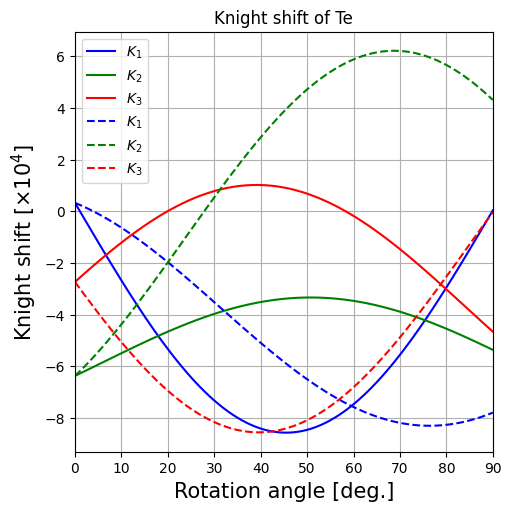

Angle,Shift1[1] value
0,0.32699472055690487
1,0.02158399740124989
2,-0.28363049878658453
3,-0.5882769111576855
4,-0.8919840749857582
5,-1.1943819698741855
6,-1.4951021705688616
7,-1.7937782958276443
8,-2.0900464547994324
9,-2.38354569036913
10,-2.6739184189282894
11,-2.96081086603565
12,-3.2438734974368035
13,-3.522761444917842
14,-3.7971349264741607
15,-4.066659660282475
16,-4.3310072719717425
17,-4.5898556946967455
18,-4.842889561526934
19,-5.089800589672462
20,-5.330287956079263
21,-5.5640586639356036
22,-5.790827899643577
23,-6.0103193798206025
24,-6.222265687908148
25,-6.42640859997764
26,-6.622499399336527
27,-6.810299179551256
28,-6.989579135517981
29,-7.160120842226311
30,-7.3217165208765635
31,-7.474169292026204
32,-7.617293415457142
33,-7.750914516471553
34,-7.874869798340608
35,-7.989008240647187
36,-8.093190783281031
37,-8.187290495862026
38,-8.27119273238534
39,-8.344795270899919
40,-8.408008438050182
41,-8.460755218329206
42,-8.50297134791024
43,-8.534605392942275
44,-8.5

In [15]:
# In the case of Te. (Te1 is on y-bond).
ks = [-8.572e-4, 1.146e-4, 0.0, -8.830e-4, 0.0, 0.0]

# ks = [-5e-4, 5e-4, 5e-4, -5e-4, 0.0, 0.0]

E = np.eye(3)
C3 = rotation_matrix([0,0,1], 2.0*np.pi/3.0) # for Te2.
C3i = C3.T # for Te3.

Rs = [E, C3i, C3]

theta, shift1, shift2 = compute_shift(n, s, ks, Rs)
plot_data(theta, shift1, shift2)

# 指定フォーマットで出力
output_shift_values(theta, shift1, shift2)

In [16]:

def save_to_csv(filename, angles, shifts, index):
    """
    Save the angles and shifts to a CSV file.

    Args:
        filename (str): Output CSV file name.
        angles (ndarray): Array of angles.
        shifts (list): Shift values for one site.
        index (int): Site index (1-based).
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header
        writer.writerow(["x", "y"])
        # Data
        for angle, shift in zip(angles, shifts):
            writer.writerow([angle, shift])

def output_shift_to_csv(theta, shift1, shift2):
    """
    Output angle and shift values to CSV files.

    Args:
        theta (ndarray): Array of angles.
        shift1 (list): Shift values for each site around n axis.
        shift2 (list): Shift values for each site around nxs axis.
    """
    # Convert angles to degrees
    angles = np.round(theta * 180 / np.pi).astype(int)  # 四捨五入で整数化
    
    # Save Shift1 data
    for i, shifts in enumerate(shift1, start=1):
        filename = f"sample({i}).csv"
        save_to_csv(filename, angles, shifts * 10000, i)
    
    # Save Shift2 data
    for i, shifts in enumerate(shift2, start=1):
        filename = f"sample{i}.csv"
        save_to_csv(filename, angles, shifts * 10000, i)

# 実行例
output_shift_to_csv(theta, shift1, shift2)

In [17]:
# 回転行列(PyTorch版)
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

# 外積(PyTorch版)
def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

# 磁場ベクトル(PyTorch版)
def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

# モデル関数(PyTorch版)
def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic((cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]))), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [18]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [19]:
# 損失関数の定義
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [20]:
# 損失関数の和
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [21]:
# 全ての順列を生成
permutations = list(itertools.permutations([0, 1, 2]))

# 最適化のためのobjective関数
def objective(trial, perm):
    # Optunaでパラメータをサンプリング
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', -18.0, 180.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    # 順列に基づいた出力の取得
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

    # 損失関数の計算
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 最適化ループ
max_global_iterations = 5  # グローバルな最大繰り返し回数
global_iteration = 0

# グローバルな最良結果を保存するための変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 損失関数が0.01以下になるまで以下の計算を繰り返す
while global_best_loss > 1e-2 and global_iteration < max_global_iterations:
    print(f"\nGlobal iteration {global_iteration + 1}")

    # 6通りの組み合わせごとにエポック計算を行うためのループ
    for perm in permutations:
        print(f"Evaluating combination: perm1={perm}, perm2={perm}")

        # 最適化のための変数初期化
        best_epoch0_loss = float('inf')
        best_params = None

        # Optunaを使用してパラメータを最適化
        for _ in range(5):
            # Optunaで最適化
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, perm), n_trials=100)

            # epoch0のLossが最小のパラメータを保持
            if study.best_value < best_epoch0_loss:
                best_epoch0_loss = study.best_value
                best_params = study.best_params

        # エポック計算 (各組み合わせごとに計算)
        if best_params is not None:
            print(f"Starting training for combination: perm1={perm}, perm2={perm}")

            # 最適化されたパラメータで初期化
            k1 = torch.nn.Parameter(torch.tensor(best_params['k1'], dtype=torch.float32))
            k2 = torch.nn.Parameter(torch.tensor(best_params['k2'], dtype=torch.float32))
            k3 = torch.nn.Parameter(torch.tensor(best_params['k3'], dtype=torch.float32))
            k4 = torch.nn.Parameter(torch.tensor(best_params['k4'], dtype=torch.float32))
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1 = torch.nn.Parameter(torch.tensor(best_params['t1'], dtype=torch.float32))
            p1 = torch.nn.Parameter(torch.tensor(best_params['p1'], dtype=torch.float32))
            t2 = torch.nn.Parameter(torch.tensor(best_params['t2'], dtype=torch.float32))
            p2 = torch.nn.Parameter(torch.tensor(best_params['p2'], dtype=torch.float32))
            
            # 既存のパラメータに新しい初期値を設定
            k1.data = torch.tensor(best_params['k1'], dtype=torch.float32)
            k2.data = torch.tensor(best_params['k2'], dtype=torch.float32)
            k3.data = torch.tensor(best_params['k3'], dtype=torch.float32)
            k4.data = torch.tensor(best_params['k4'], dtype=torch.float32)
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1.data = torch.tensor(best_params['t1'], dtype=torch.float32)
            p1.data = torch.tensor(best_params['p1'], dtype=torch.float32)
            t2.data = torch.tensor(best_params['t2'], dtype=torch.float32)
            p2.data = torch.tensor(best_params['p2'], dtype=torch.float32)

            optimizer = optim.Adam([k1, k2, k3, k4, t1, p1, t2, p2], lr=1e-1)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
            prev_loss = float('inf')

            # エポックごとのトレーニング
            best_params_during_epoch = None  # エポックごとの最良パラメータ
            best_epoch_loss = float('inf')  # 最良のロスを記録

            # Early Stopping を導入
            early_stopping_patience = 1000
            no_improvement_counter = 0

            # エポックごとのトレーニング
            for epoch in range(300000):
                optimizer.zero_grad()

                outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

                y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
                y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

                loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

                if epoch == 0:
                    epoch0_loss = loss.item()
                    if epoch0_loss >= 35:
                        print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                        break
                
                # 最良のロスを持つ場合はパラメータを保存
                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {
                        'k1': k1.item(),
                        'k2': k2.item(),
                        'k3': k3.item(),
                        'k4': k4.item(),
                        'k5': k5.item(),
                        'k6': k6.item(),
                        't1': t1.item(),
                        'p1': p1.item(),
                        't2': t2.item(),
                        'p2': p2.item()
                    }

                if loss.item() > prev_loss:
                    print(f"Loss increased at epoch {epoch}. Stopping training.")
                    break

                prev_loss = loss.item()
                loss.backward()

                optimizer.step()

                # 学習率の更新
                scheduler.step()

                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {...}  # 保存処理
                    no_improvement_counter = 0  # リセット
                else:
                    no_improvement_counter += 1

                if no_improvement_counter >= early_stopping_patience:
                    print(f"Stopping early at epoch {epoch} due to no improvement.")
                    break

                with torch.no_grad():
                    for param in [k1, k2, k3, k4]:
                        param.data = torch.clamp(param.data, -10.0, 10.0)
                    for param in [k4]:
                        param.data = torch.clamp(param.data, -10.0, 10.0)
                    for param in [t1, t2]:
                        param.data = torch.clamp(param.data, 0.0, 180.0)
                    for param in [p1]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)
                    for param in [p2]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)

                if epoch % 100 == 0:
                    # 勾配を確認（必要に応じて）
                    # for name, param in zip(['k1', 'k2', 'k3', 'k4', 't1', 'p1', 't2', 'p2'], [k1, k2, k3, k4, t1, p1, t2, p2]):
                    #     print(f"{name} grad: {param.grad}")
                    print(f'Epoch {epoch}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()}')
                    # パラメータを表示する
                    print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

            # 最良のパラメータを表示
            if best_params_during_epoch is not None:
                print(f"Best params during epoch training: {best_params_during_epoch}")
                # 最良のパラメータをTensorに変換して使用
                k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
            else:
                print("No improvement in loss during epoch training.")

            # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
            if prev_loss < global_best_loss:
                global_best_loss = prev_loss
                global_best_params = best_params_during_epoch
                global_best_combination = (perm, perm)

            print(f"Finished training for combination: perm1={perm}, perm2={perm}")


    print(f"Global best Loss after iteration {global_iteration + 1}: {global_best_loss}")
    global_iteration += 1

print(f"\nOptimization completed.")
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2025-01-15 14:06:53,108] A new study created in memory with name: no-name-dbe17d1e-9c04-4c4a-a5d5-0a1ebd802383



Global iteration 1
Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2025-01-15 14:06:53,218] Trial 0 finished with value: 274.1645202636719 and parameters: {'k1': -2.0826550268413646, 'k2': 6.789491317781405, 'k3': -7.689226395191627, 'k4': -0.6229666099356415, 't1': 175.78488138556133, 'p1': 37.506240200398565, 't2': 103.08589238867117, 'p2': -12.55380860098204}. Best is trial 0 with value: 274.1645202636719.
[I 2025-01-15 14:06:53,272] Trial 1 finished with value: 380.1360168457031 and parameters: {'k1': 2.8795758096072195, 'k2': 5.379162755357598, 'k3': -2.960643732388273, 'k4': -4.3535292199456705, 't1': 140.42893472391003, 'p1': 102.79348467021197, 't2': 63.081523377254804, 'p2': 20.00350216064576}. Best is trial 0 with value: 274.1645202636719.
[I 2025-01-15 14:06:53,324] Trial 2 finished with value: 120.95890808105469 and parameters: {'k1': -3.478679586518279, 'k2': 2.3676217504266432, 'k3': -6.40841374951953, 'k4': 9.784573554145158, 't1': 68.81997164397097, 'p1': -8.233637192758323, 't2': 152.8549352669126, 'p2': 59.35484610180929}. Best is

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 25.16861915588379, LR: [0.1]
Parameters: k1=-4.670150279998779, k2=3.4516704082489014, k3=-4.652414798736572, k4=-6.585554122924805, k5=0.0, k6=0.0, t1=95.74636840820312, p1=169.66912841796875, t2=174.69496154785156, p2=70.08038330078125
Epoch 100, Loss: 7.758881568908691, LR: [0.1]
Parameters: k1=-8.868128776550293, k2=3.4850549697875977, k3=-3.618640661239624, k4=-7.072769641876221, k5=0.0, k6=0.0, t1=86.20005798339844, p1=169.9567108154297, t2=168.0939178466797, p2=81.20484161376953
Epoch 200, Loss: 4.858437538146973, LR: [0.1]
Parameters: k1=-9.341083526611328, k2=3.964134454727173, k3=-3.6151037216186523, k4=-7.258622169494629, k5=0.0, k6=0.0, t1=79.65612030029297, p1=170.94410705566406, t2=167.27015686035156, p2=91.57765197753906
Epoch 300, Loss: 3.4606451988220215, LR: [0.1]
Parameters: k1=-9.572317123413086, k2=4.185429096221924, k3=-3.609261989593506, k4=-7.3880615234375, k5=0.0, k6=0.0, t1=76.5

[I 2025-01-15 14:09:18,621] A new study created in memory with name: no-name-fdcbaa84-d7a5-42f1-a9f6-aac13303f78a
[I 2025-01-15 14:09:18,682] Trial 0 finished with value: 237.53488159179688 and parameters: {'k1': -7.292961208291779, 'k2': 7.286164837170034, 'k3': 1.5628083419677452, 'k4': 1.8526341624960292, 't1': 170.78257686934614, 'p1': -113.83994118488192, 't2': 62.66982350512174, 'p2': -9.546835660244502}. Best is trial 0 with value: 237.53488159179688.
[I 2025-01-15 14:09:18,739] Trial 1 finished with value: 142.77813720703125 and parameters: {'k1': -9.786774865154666, 'k2': 2.6094978202185715, 'k3': -8.181888642585342, 'k4': -5.286192920324922, 't1': 148.0743144576436, 'p1': 137.85386392347112, 't2': 51.24757355658958, 'p2': -1.3534510991319344}. Best is trial 1 with value: 142.77813720703125.
[I 2025-01-15 14:09:18,796] Trial 2 finished with value: 216.55157470703125 and parameters: {'k1': 9.285246869736017, 'k2': 4.679831465341078, 'k3': -7.0037361904953315, 'k4': -1.582151788

Stopping early at epoch 999 due to no improvement.
Best params during epoch training: {'k1': -9.768836975097656, 'k2': 4.354616641998291, 'k3': -3.5878496170043945, 'k4': -7.647387504577637, 'k5': 0.0, 'k6': 0.0, 't1': 73.7072525024414, 'p1': 174.62193298339844, 't2': 167.29061889648438, 'p2': 117.83396911621094}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2025-01-15 14:09:18,854] Trial 3 finished with value: 326.3528747558594 and parameters: {'k1': 1.4163476141954678, 'k2': -5.067899554120434, 'k3': 0.11197226257182535, 'k4': 8.94318312294969, 't1': 172.64767622254428, 'p1': 50.34289658120551, 't2': 141.7663181468355, 'p2': -12.04617613074789}. Best is trial 1 with value: 142.77813720703125.
[I 2025-01-15 14:09:18,913] Trial 4 finished with value: 112.01942443847656 and parameters: {'k1': -1.2536096796284983, 'k2': 5.499199398120922, 'k3': -4.404337955925033, 'k4': 1.2017440230504572, 't1': 124.95179679351962, 'p1': -30.76484465976037, 't2': 31.356995901322932, 'p2': 92.10362619865644}. Best is trial 4 with value: 112.01942443847656.
[I 2025-01-15 14:09:18,969] Trial 5 finished with value: 256.28936767578125 and parameters: {'k1': 1.491018262922097, 'k2': -7.332059580721371, 'k3': 6.090570570027616, 'k4': 9.245459054086528, 't1': 91.55461620131001, 'p1': -31.52597098364754, 't2': 86.05460191563711, 'p2': 132.43353341394047}. Best is 

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Epoch 0, Loss: 21.54743766784668, LR: [0.1]
Parameters: k1=-7.2554144859313965, k2=2.161283493041992, k3=-3.2634334564208984, k4=-8.66555118560791, k5=0.0, k6=0.0, t1=112.98536682128906, p1=-171.51388549804688, t2=4.45513916015625, p2=177.10263061523438


[I 2025-01-15 14:09:59,884] A new study created in memory with name: no-name-9773261f-adba-4cc2-9672-84605b433425
[I 2025-01-15 14:09:59,942] Trial 0 finished with value: 163.5118408203125 and parameters: {'k1': -7.365329913513943, 'k2': 1.297948199230138, 'k3': -5.723152164698641, 'k4': 2.3786531963119177, 't1': 147.40226415229913, 'p1': 71.45652310799741, 't2': 35.32782753439593, 'p2': -3.5071751569244043}. Best is trial 0 with value: 163.5118408203125.
[I 2025-01-15 14:09:59,999] Trial 1 finished with value: 257.1181640625 and parameters: {'k1': -8.124813882501405, 'k2': 4.953194902457032, 'k3': -9.029894900667896, 'k4': -3.379110682113553, 't1': 130.55954343268797, 'p1': -164.42174869667093, 't2': 61.17040580394696, 'p2': 133.76023802694723}. Best is trial 0 with value: 163.5118408203125.
[I 2025-01-15 14:10:00,055] Trial 2 finished with value: 264.21075439453125 and parameters: {'k1': 6.618162856063517, 'k2': -4.404188227561436, 'k3': -1.2221186828911215, 'k4': 1.284881465790475, 

Loss increased at epoch 48. Stopping training.
Best params during epoch training: {'k1': -7.715609550476074, 'k2': 1.9027765989303589, 'k3': -3.5520377159118652, 'k4': -6.842235088348389, 'k5': 0.0, 'k6': 0.0, 't1': 111.4644775390625, 'p1': -169.08358764648438, 't2': 7.202808380126953, 'p2': 180.0}
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2025-01-15 14:10:00,113] Trial 3 finished with value: 232.03428649902344 and parameters: {'k1': -4.026425232979076, 'k2': -9.856259117328982, 'k3': 8.510925545789632, 'k4': -1.171459681651525, 't1': 157.70152822675178, 'p1': -49.12665238372455, 't2': 81.0767924758577, 'p2': -6.4289059091509415}. Best is trial 0 with value: 163.5118408203125.
[I 2025-01-15 14:10:00,171] Trial 4 finished with value: 104.19601440429688 and parameters: {'k1': 4.258216496377292, 'k2': -9.185631805632653, 'k3': -2.700231430932849, 'k4': -8.291818340517699, 't1': 95.30304031073987, 'p1': 76.19672822376884, 't2': 10.933213664533508, 'p2': 87.3605164022577}. Best is trial 4 with value: 104.19601440429688.
[I 2025-01-15 14:10:00,227] Trial 5 finished with value: 551.2969360351562 and parameters: {'k1': 2.585692857756438, 'k2': 5.94421167152327, 'k3': 6.941724742102842, 'k4': -5.659388263150216, 't1': 61.04885036725207, 'p1': -109.36991149479415, 't2': 167.46907105714592, 'p2': 48.21909672749176}. Best is tria

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Epoch 0, Loss: 34.7244873046875, LR: [0.1]
Parameters: k1=-5.894540309906006, k2=-0.23922553658485413, k3=-9.774280548095703, k4=6.359277248382568, k5=0.0, k6=0.0, t1=160.24990844726562, p1=-13.252453804016113, t2=114.64970397949219, p2=98.71977996826172
Epoch 100, Loss: 2.1580095291137695, LR: [0.1]
Parameters: k1=-8.152356147766113, k2=1.234259843826294, k3=-2.2826766967773438, k4=9.645002365112305, k5=0.0, k6=0.0, t1=152.17129516601562, p1=-20.0848445892334, t2=115.18791198730469, p2=95.49878692626953
Epoch 200, Loss: 0.32158005237579346, LR: [0.1]
Parameters: k1=-8.495360374450684, k2=1.147122859954834, k3=-0.1696142703294754, k4=9.26941967010498, k5=0.0, k6=0.0, t1=149.55775451660156, p1=-31.34065818786621, t2=116.42485809326172, p2=96.23497009277344
Epoch 300, Loss: 0.07456696033477783, LR: [0.1]
Parameters: k1=-8.551924705505371, k2=1.144238829612732, k3=0.020802319049835205, k4=9.036768913269043, k5=0.0, k6=0.0

[I 2025-01-15 14:11:49,983] A new study created in memory with name: no-name-dd40d06a-d3fb-4d15-b74d-3ffddbf78c49
[I 2025-01-15 14:11:50,040] Trial 0 finished with value: 333.3463439941406 and parameters: {'k1': 9.374846987546238, 'k2': -9.32404506504118, 'k3': 5.1576547374842345, 'k4': -3.614998714162785, 't1': 104.38159265165785, 'p1': 26.151272861831814, 't2': 57.37428299391601, 'p2': 66.36586778495686}. Best is trial 0 with value: 333.3463439941406.
[I 2025-01-15 14:11:50,152] Trial 1 finished with value: 765.1659545898438 and parameters: {'k1': 9.213761757942681, 'k2': 5.794428920203227, 'k3': 8.151006061163748, 'k4': 0.4211972677771634, 't1': 66.27323011063217, 'p1': 57.49716222817358, 't2': 18.9749545646858, 'p2': 100.08134237171238}. Best is trial 0 with value: 333.3463439941406.


Loss increased at epoch 679. Stopping training.
Best params during epoch training: {'k1': -8.572515487670898, 'k2': 1.1459136009216309, 'k3': 0.0006673492607660592, 'k4': 8.83417797088623, 'k5': 0.0, 'k6': 0.0, 't1': 145.8657989501953, 'p1': -42.82944869995117, 't2': 117.40184020996094, 'p2': 96.84388732910156}
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2025-01-15 14:11:50,211] Trial 2 finished with value: 155.76219177246094 and parameters: {'k1': -0.19031534144296636, 'k2': -8.647961879785392, 'k3': -5.0143717814682365, 'k4': 9.433208075858829, 't1': 159.24558494168318, 'p1': -167.9137334545793, 't2': 7.580776370472549, 'p2': -4.638507593776032}. Best is trial 2 with value: 155.76219177246094.
[I 2025-01-15 14:11:50,270] Trial 3 finished with value: 118.8396987915039 and parameters: {'k1': -5.955215980013559, 'k2': 2.4243430775022823, 'k3': -6.20138823834822, 'k4': -5.9938232611250974, 't1': 175.40861370905182, 'p1': 111.86040061682206, 't2': 8.879142176426747, 'p2': -0.3184841851089466}. Best is trial 3 with value: 118.8396987915039.
[I 2025-01-15 14:11:50,328] Trial 4 finished with value: 170.79815673828125 and parameters: {'k1': -2.136545942043835, 'k2': -1.0559571746866467, 'k3': 0.35956988089790265, 'k4': 5.532489397511576, 't1': 16.865818411195487, 'p1': 83.22062884040116, 't2': 6.115416830543534, 'p2': -14.670581958430734}.

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Epoch 0, Loss: 24.28813934326172, LR: [0.1]
Parameters: k1=-4.9453816413879395, k2=-0.23432955145835876, k3=-2.1750340461730957, k4=5.769235134124756, k5=0.0, k6=0.0, t1=69.60359191894531, p1=-140.92774963378906, t2=171.1593017578125, p2=152.92359924316406
Epoch 100, Loss: 3.810288190841675, LR: [0.1]
Parameters: k1=-9.447514533996582, k2=3.962293863296509, k3=-3.6160216331481934, k4=7.0306477546691895, k5=0.0, k6=0.0, t1=69.03662872314453, p1=-131.46754455566406, t2=167.6931610107422, p2=160.82229614257812
Epoch 200, Loss: 2.518758773803711, LR: [0.1]
Parameters: k1=-9.707676887512207, k2=4.2718706130981445, k3=-3.5993480682373047, k4=7.422010898590088, k5=0.0, k6=0.0, t1=72.0305404663086, p1=-127.54171752929688, t2=167.2187957763672, p2=170.1055450439453
Epoch 300, Loss: 2.2615468502044678, LR: [0.1]
Parameters: k1=-9.749937057495117, k2=4.33574914932251, k3=-3.5919485092163086, k4=7.586894512176514, k5=0.0, k6=0.0, 

[I 2025-01-15 14:13:26,327] A new study created in memory with name: no-name-9fb6f916-8762-4ae6-9d54-6c98ae92a65d
[I 2025-01-15 14:13:26,383] Trial 0 finished with value: 436.1905517578125 and parameters: {'k1': -7.57136932458776, 'k2': 8.687818513663377, 'k3': 5.783535229155522, 'k4': 7.514933835502767, 't1': 28.530968966695415, 'p1': 97.19039013725575, 't2': 127.56775868954206, 'p2': 59.11125683872635}. Best is trial 0 with value: 436.1905517578125.
[I 2025-01-15 14:13:26,437] Trial 1 finished with value: 741.8380126953125 and parameters: {'k1': 1.1511159005052836, 'k2': -1.0379584372794781, 'k3': 8.498519203127067, 'k4': 8.786019002322256, 't1': 29.488978118967715, 'p1': -48.716819442158084, 't2': 174.76420037223247, 'p2': 157.98814193859894}. Best is trial 0 with value: 436.1905517578125.
[I 2025-01-15 14:13:26,490] Trial 2 finished with value: 624.236328125 and parameters: {'k1': 5.23310957276793, 'k2': 9.911703040289396, 'k3': 0.6036574032965625, 'k4': 0.6155787041259391, 't1': 1

Loss increased at epoch 552. Stopping training.
Best params during epoch training: {'k1': -9.768446922302246, 'k2': 4.353537559509277, 'k3': -3.587566614151001, 'k4': 7.648740291595459, 'k5': 0.0, 'k6': 0.0, 't1': 73.67936706542969, 'p1': -125.35803985595703, 't2': 167.2950439453125, 'p2': 178.0261993408203}
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2025-01-15 14:13:26,545] Trial 3 finished with value: 211.900634765625 and parameters: {'k1': -1.2226739816377155, 'k2': 5.680097345446031, 'k3': -9.92793996010096, 'k4': -0.530864536280804, 't1': 158.9576273562545, 'p1': 116.4772098949827, 't2': 0.7805140415712231, 'p2': 82.52378839200429}. Best is trial 3 with value: 211.900634765625.
[I 2025-01-15 14:13:26,656] Trial 4 finished with value: 209.470703125 and parameters: {'k1': 4.261786862239795, 'k2': 8.655052073924555, 'k3': -4.900885155650576, 'k4': -1.321682380530964, 't1': 56.30715202179087, 'p1': 7.202105194565036, 't2': 158.37131455790364, 'p2': 177.2086850866033}. Best is trial 4 with value: 209.470703125.
[I 2025-01-15 14:13:26,709] Trial 5 finished with value: 181.61106872558594 and parameters: {'k1': -2.587808010242229, 'k2': -9.829070657278049, 'k3': 4.176893643594417, 'k4': -0.24761265520625386, 't1': 83.70088441452523, 'p1': 94.67558746708977, 't2': 35.5350302916128, 'p2': 85.93541633344148}. Best is trial 5 with valu

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 20.89359474182129, LR: [0.1]
Parameters: k1=-5.929553031921387, k2=-2.3678300380706787, k3=0.3556070327758789, k4=-7.9759721755981445, k5=0.0, k6=0.0, t1=17.80280113220215, p1=145.570068359375, t2=73.60063171386719, p2=87.84004974365234
Epoch 100, Loss: 9.854543685913086, LR: [0.1]
Parameters: k1=-7.346055507659912, k2=0.07691936194896698, k3=-1.1244738101959229, k4=-10.0, k5=0.0, k6=0.0, t1=27.769208908081055, p1=156.1116943359375, t2=70.24043273925781, p2=87.4371109008789
Epoch 200, Loss: 6.708104133605957, LR: [0.1]
Parameters: k1=-7.794036388397217, k2=0.4928528368473053, k3=-0.5861030220985413, k4=-10.0, k5=0.0, k6=0.0, t1=28.829479217529297, p1=165.48825073242188, t2=68.47049713134766, p2=88.15361785888672
Epoch 300, Loss: 4.683359146118164, LR: [0.1]
Parameters: k1=-8.058698654174805, k2=0.7359468936920166, k3=-0.291206032037735, k4=-10.0, k5=0.0, k6=0.0, t1=28.627017974853516, p1=173.428283691406

[I 2025-01-15 14:14:45,219] A new study created in memory with name: no-name-f4df98b3-70d7-47c0-9d7e-04a3a6189634
[I 2025-01-15 14:14:45,278] Trial 0 finished with value: 282.9671325683594 and parameters: {'k1': -8.127346732788476, 'k2': -2.255232153882158, 'k3': 2.4023536843372817, 'k4': -7.92367335315933, 't1': 153.59831271141707, 'p1': 61.78224678950207, 't2': 95.68398912540589, 'p2': -11.449391223138964}. Best is trial 0 with value: 282.9671325683594.
[I 2025-01-15 14:14:45,335] Trial 1 finished with value: 63.551551818847656 and parameters: {'k1': -8.536999280679291, 'k2': 5.336624688886102, 'k3': -5.544627605409964, 'k4': 3.123341482757219, 't1': 48.183272710245355, 'p1': -31.05455713071433, 't2': 120.33617165820007, 'p2': 79.66558747662732}. Best is trial 1 with value: 63.551551818847656.
[I 2025-01-15 14:14:45,391] Trial 2 finished with value: 139.1726531982422 and parameters: {'k1': -6.46078742205646, 'k2': -4.686349675238713, 'k3': -4.116654547986631, 'k4': -7.072564977069316

Loss increased at epoch 398. Stopping training.
Best params during epoch training: {'k1': -8.251078605651855, 'k2': 0.9107345342636108, 'k3': -0.1065765768289566, 'k4': -10.0, 'k5': 0.0, 'k6': 0.0, 't1': 28.628795623779297, 'p1': 180.0, 't2': 66.265625, 'p2': 87.17324829101562}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2025-01-15 14:14:45,450] Trial 3 finished with value: 86.69194030761719 and parameters: {'k1': -4.872709891564259, 'k2': 0.2938344753691595, 'k3': -4.119442571450511, 'k4': 3.3701232776393812, 't1': 168.41273113935492, 'p1': 60.223346809714, 't2': 42.62042186243694, 'p2': 123.98792110874248}. Best is trial 1 with value: 63.551551818847656.
[I 2025-01-15 14:14:45,508] Trial 4 finished with value: 454.65118408203125 and parameters: {'k1': 0.987037773370476, 'k2': 7.695964085930854, 'k3': 3.993439348688586, 'k4': 3.933828375608538, 't1': 85.04683691707392, 'p1': -164.46072961777776, 't2': 168.3010585094903, 'p2': 48.59796635532449}. Best is trial 1 with value: 63.551551818847656.
[I 2025-01-15 14:14:45,619] Trial 5 finished with value: 460.7109375 and parameters: {'k1': -6.728122165330504, 'k2': 4.959900161982562, 'k3': 7.807693648655874, 'k4': -5.968391273802935, 't1': 69.40956213416752, 'p1': -40.30312435791052, 't2': 121.9107044474394, 'p2': 0.08201333690569612}. Best is trial 1 wit

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 26.212697982788086, LR: [0.1]
Parameters: k1=-6.936920642852783, k2=4.791656494140625, k3=-4.237318992614746, k4=6.031817436218262, k5=0.0, k6=0.0, t1=134.60093688964844, p1=153.70379638671875, t2=8.918184280395508, p2=141.1878662109375
Epoch 100, Loss: 11.616401672363281, LR: [0.1]
Parameters: k1=-10.0, k2=3.671274423599243, k3=-3.616302967071533, k4=6.689898490905762, k5=0.0, k6=0.0, t1=128.88824462890625, p1=144.80064392089844, t2=5.88139533996582, p2=151.38877868652344
Epoch 200, Loss: 6.98128080368042, LR: [0.1]
Parameters: k1=-10.0, k2=3.864356517791748, k3=-3.5937564373016357, k4=6.9267449378967285, k5=0.0, k6=0.0, t1=125.64723205566406, p1=137.6538543701172, t2=8.797832489013672, p2=165.17210388183594
Epoch 300, Loss: 3.799686908721924, LR: [0.1]
Parameters: k1=-9.83962631225586, k2=4.063320636749268, k3=-3.5882115364074707, k4=7.133304595947266, k5=0.0, k6=0.0, t1=119.01396179199219, p1=131.6730

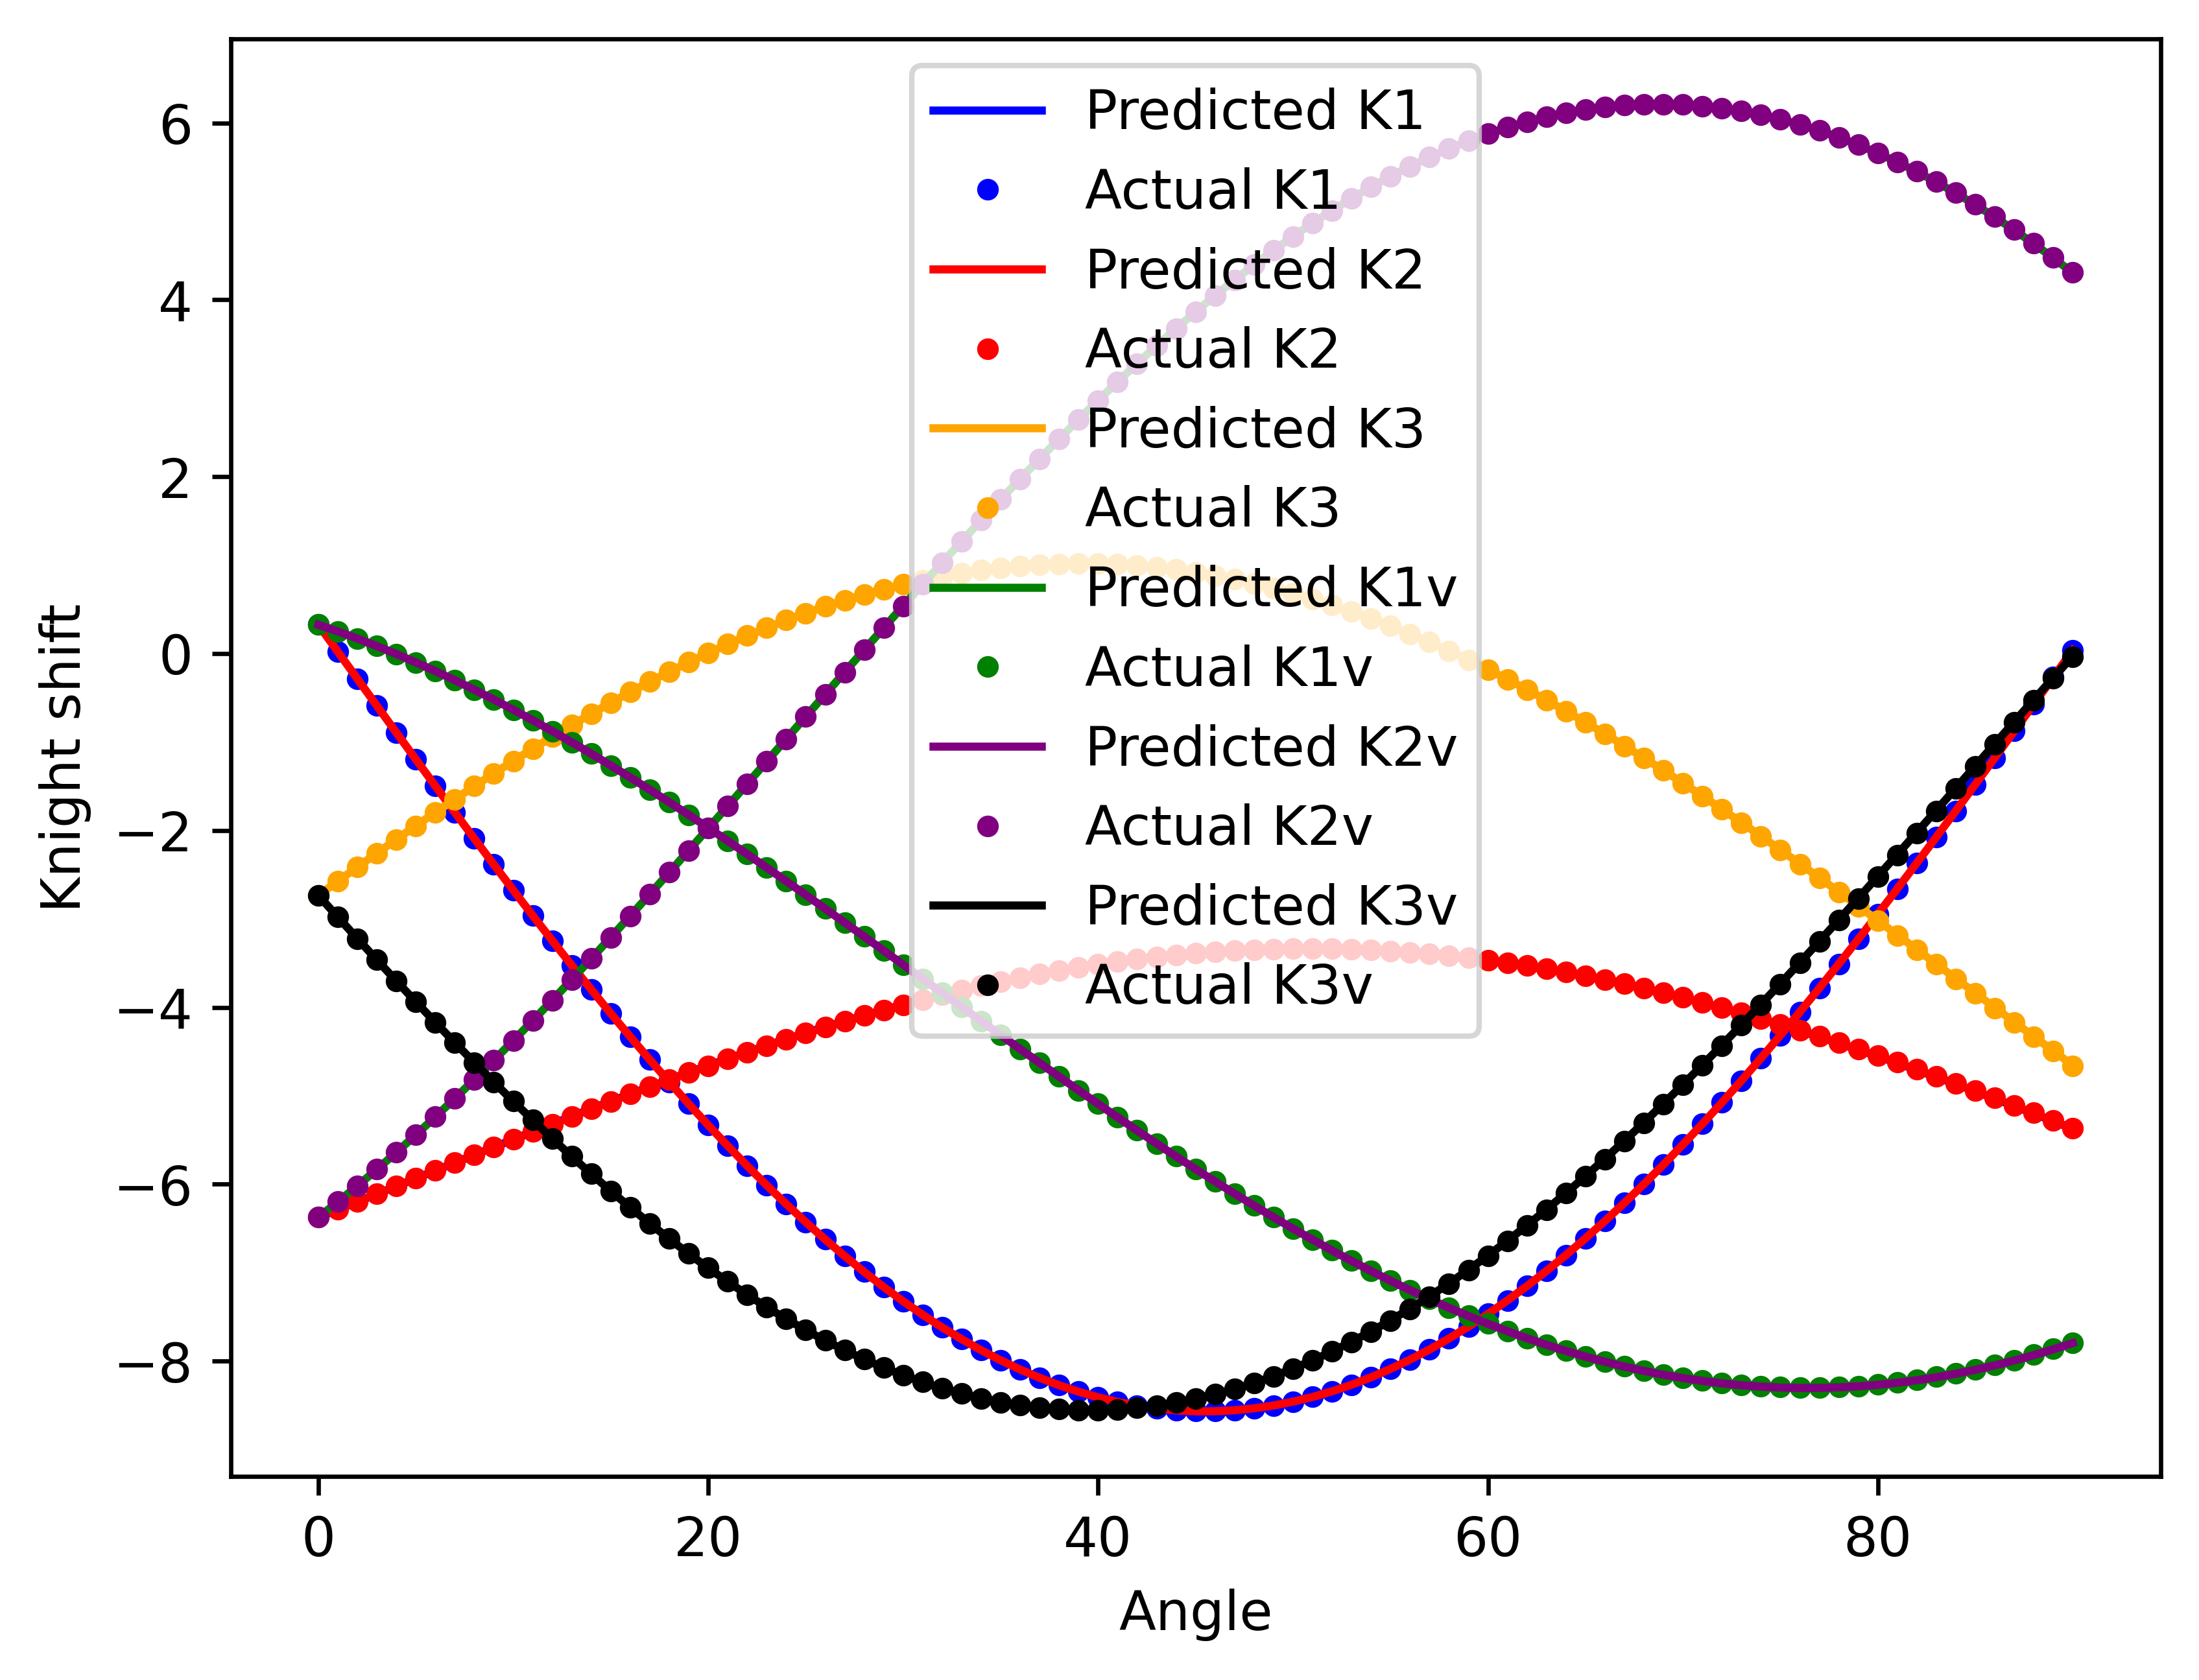

{'k1': -8.572515487670898, 'k2': 1.1459136009216309, 'k3': 0.0006673492607660592, 'k4': 8.83417797088623, 'k5': 0.0, 'k6': 0.0, 't1': 145.8657989501953, 'p1': -42.82944869995117, 't2': 117.40184020996094, 'p2': 96.84388732910156}


In [22]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)